In [1]:
from google.colab import userdata
import os
import keras

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
!kaggle competitions download -c dogs-vs-cats
! mkdir cats_vs_dogs
! unzip "dogs-vs-cats.zip" -d cats_vs_dogs
! mkdir cats_vs_dogs/train_data
! unzip "cats_vs_dogs/train.zip" -d cats_vs_dogs/train_data

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘cats_vs_dogs’: File exists
Archive:  dogs-vs-cats.zip
replace cats_vs_dogs/sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: mkdir: cannot create directory ‘cats_vs_dogs/train_data’: File exists
Archive:  cats_vs_dogs/train.zip
replace cats_vs_dogs/train_data/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import os
import shutil
import random

# Ścieżka do katalogu, w którym znajdują się pobrane zdjęcia
downloaded_data_directory = 'cats_vs_dogs/train_data/train'

# Ścieżka do głównego katalogu, w którym będziemy tworzyć podkatalogi dla treningu i walidacji
main_directory = 'cats_vs_dogs'

# Tworzenie katalogów train i validation w głównym katalogu
train_dir = os.path.join(main_directory, 'train')
validation_dir = os.path.join(main_directory, 'validation')
test_dir = os.path.join(main_directory, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Liczba zdjęć treningowych i walidacyjnych dla każdej klasy
num_train_images = 2000 // 2  # 1000 zdjęć na klasę
num_validation_images = 1000 // 2  # 500 zdjęć na klasę
num_test_images = 500

# Tworzenie podkatalogów dla poszczególnych klas w katalogach treningowych i walidacyjnych
classes = ['cat', 'dog']
for dataset_type in ['train', 'validation', 'test']:
    for class_name in classes:
        class_dir = os.path.join(main_directory, dataset_type, class_name)
        os.makedirs(class_dir, exist_ok=True)

# Przesuwanie zdjęć do odpowiednich katalogów treningowych i walidacyjnych
for class_name in classes:
    # Pobranie listy wszystkich zdjęć danej klasy
    class_images = [filename for filename in os.listdir(downloaded_data_directory) if filename.startswith(class_name)]
    random.shuffle(class_images)  # Losowa permutacja zdjęć

    # Przesunięcie zdjęć do katalogów treningowych
    for img in class_images[:num_train_images]:
        src = os.path.join(downloaded_data_directory, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy(src, dst)

    # Przesunięcie zdjęć do katalogów walidacyjnych
    for img in class_images[num_train_images:num_train_images + num_validation_images]:
        src = os.path.join(downloaded_data_directory, img)
        dst = os.path.join(validation_dir, class_name, img)
        shutil.copy(src, dst)
    # przesuniecie do testowego
    for img in class_images[num_train_images+ num_validation_images:num_train_images + num_validation_images + num_test_images]:
        src = os.path.join(downloaded_data_directory, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copy(src, dst)

print("Organizacja danych zakończona.")

Organizacja danych zakończona.


In [3]:
from tensorflow.keras.preprocessing import  image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'cats_vs_dogs/train',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)
val_dataset = image_dataset_from_directory(
    'cats_vs_dogs/validation',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)
test_dataset = image_dataset_from_directory(
    'cats_vs_dogs/test',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
from keras import models
from keras import layers

data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=(0.2, 0.3)),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomContrast(0.2)])

model = models.Sequential()
model.add(layers.Rescaling(1./255., input_shape=(150,150,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [6]:
opt = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [7]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
100/100 [==============================] - 11s 43ms/step - loss: 0.6935 - accuracy: 0.5175 - val_loss: 0.6875 - val_accuracy: 0.6030
Epoch 2/30
100/100 [==============================] - 4s 37ms/step - loss: 0.6897 - accuracy: 0.5375 - val_loss: 0.6845 - val_accuracy: 0.5050
Epoch 3/30
100/100 [==============================] - 4s 34ms/step - loss: 0.6863 - accuracy: 0.5420 - val_loss: 0.6716 - val_accuracy: 0.6010
Epoch 4/30
100/100 [==============================] - 4s 37ms/step - loss: 0.6791 - accuracy: 0.5675 - val_loss: 0.6613 - val_accuracy: 0.6450
Epoch 5/30
100/100 [==============================] - 5s 45ms/step - loss: 0.6728 - accuracy: 0.5825 - val_loss: 0.6613 - val_accuracy: 0.6320
Epoch 6/30
100/100 [==============================] - 4s 34ms/step - loss: 0.6675 - accuracy: 0.5935 - val_loss: 0.6498 - val_accuracy: 0.6300
Epoch 7/30
100/100 [==============================] - 4s 38ms/step - loss: 0.6557 - accuracy: 0.6165 - val_loss: 0.6727 - val_accuracy: 0.564

In [8]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'loss')

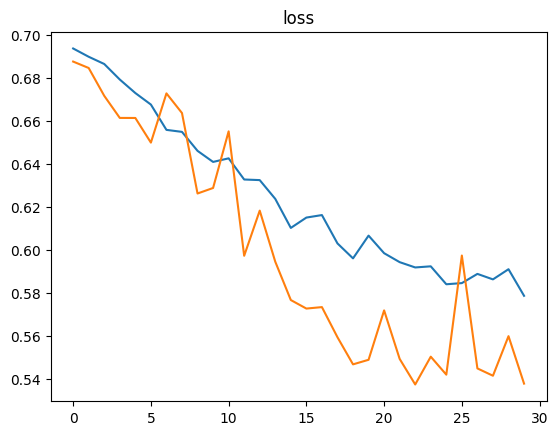

In [9]:
import matplotlib.pyplot as plt

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

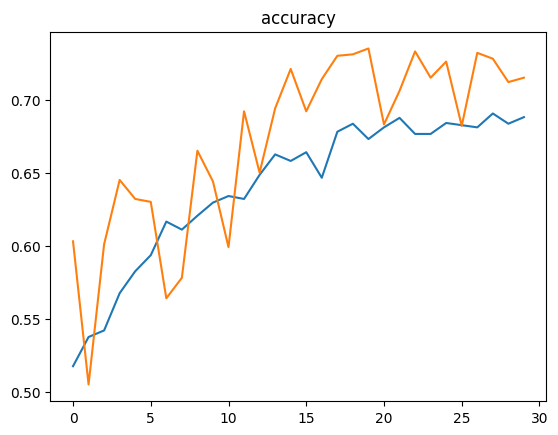

In [10]:
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('accuracy')

In [4]:
from keras import models
from keras import layers

data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=(0.2, 0.3)),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomContrast(0.2)])

model = models.Sequential()
model.add(layers.Rescaling(1./255., input_shape=(150,150,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [5]:
opt = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [6]:
history = model.fit(
      train_dataset,
      steps_per_epoch=100,
      epochs=100,
      validation_data=val_dataset,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 10s 37ms/step - loss: 0.6957 - accuracy: 0.5105 - val_loss: 0.6886 - val_accuracy: 0.5100
Epoch 2/100
100/100 [==============================] - 4s 38ms/step - loss: 0.6897 - accuracy: 0.5320 - val_loss: 0.6822 - val_accuracy: 0.5750
Epoch 3/100
100/100 [==============================] - 4s 39ms/step - loss: 0.6883 - accuracy: 0.5540 - val_loss: 0.6786 - val_accuracy: 0.5660
Epoch 4/100
100/100 [==============================] - 4s 34ms/step - loss: 0.6833 - accuracy: 0.5585 - val_loss: 0.6667 - val_accuracy: 0.6200
Epoch 5/100
100/100 [==============================] - 5s 48ms/step - loss: 0.6787 - accuracy: 0.5735 - val_loss: 0.6620 - val_accuracy: 0.6140
Epoch 6/100
100/100 [==============================] - 3s 33ms/step - loss: 0.6685 - accuracy: 0.5895 - val_loss: 0.6513 - val_accuracy: 0.6230
Epoch 7/100
100/100 [==============================] - 4s 37ms/step - loss: 0.6616 - accuracy: 0.6100 - val_loss: 0.6435 - val_accuracy

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'loss')

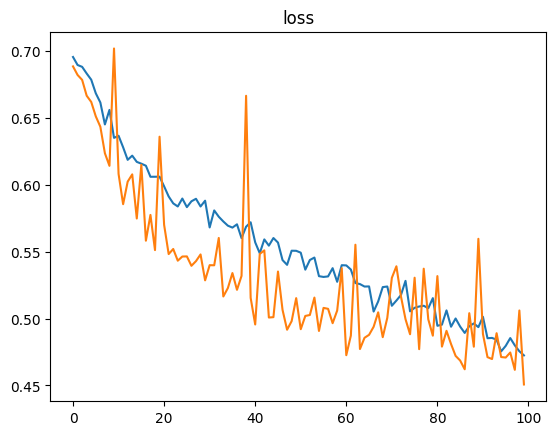

In [8]:
import matplotlib.pyplot as plt

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

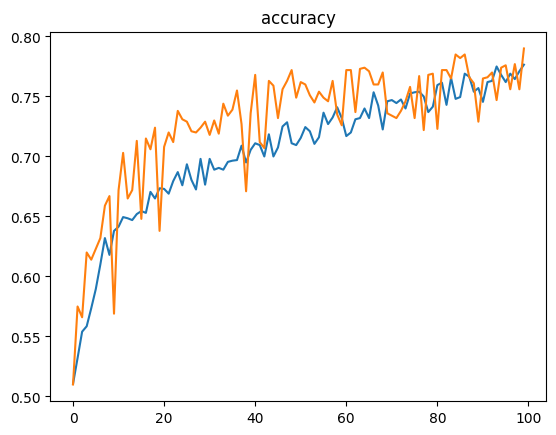

In [9]:
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('accuracy')

In [10]:
from keras import models
from keras import layers

data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=(0.2, 0.3)),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomContrast(0.2)])

model = models.Sequential()
model.add(layers.Rescaling(1./255., input_shape=(150,150,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(96, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])
history = model.fit(
      train_dataset,
      steps_per_epoch=100,
      epochs=100,
      validation_data=val_dataset,
      validation_steps=50)

Text(0.5, 1.0, 'loss')

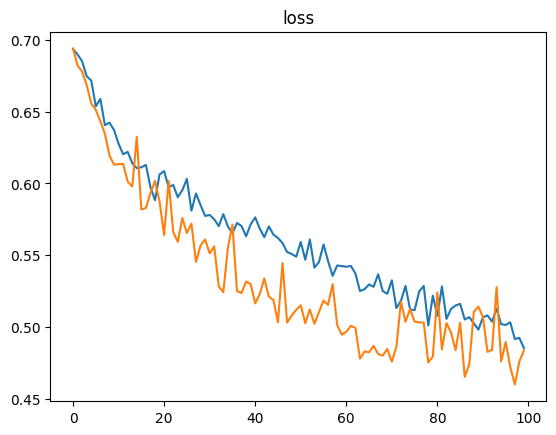

In [13]:
history_dict = history.history
history_dict.keys()
import matplotlib.pyplot as plt

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

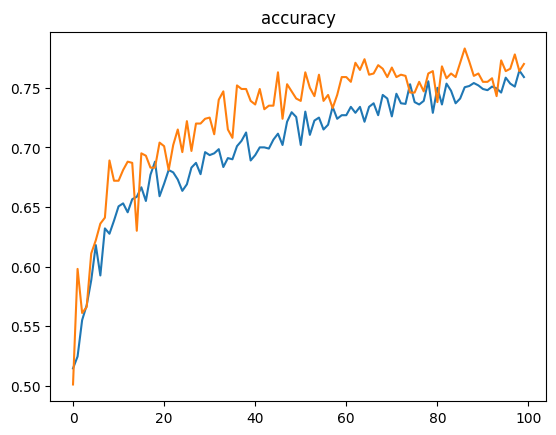

In [14]:
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('accuracy')